# Exploring Ensemble Methods
## Module 8 Boosting Assignment 1: Using pandas and sklearn Boosting Tree

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in GraphLab Create. You will:

* Use SFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.


### 3.2.4.3.5. [sklearn.ensemble.GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
Gradient Boosting for classification.

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.

Boosting algorithms play a crucial role in dealing with bias variance trade-off.  Unlike bagging algorithms, which only controls for high variance in a model, boosting controls both the aspects (bias & variance), and is considered to be more effective.  A sincere understanding of GBM here should give you much needed confidence to deal with such critical issues.

see also presentation by Owen Chang [here](http://nycdatascience.com/featured-talk-1-kaggle-data-scientist-owen-zhang/)  and a condensed version at [vidhya](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)
## Fire up pandas

In [93]:
#Import libraries:
import sframe as sf
import pandas as pd
import numpy as np

#pd.canvas.set_target('ipynb')
from __future__ import division  #ensures floating point division

from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics            #Additional scklearn functions
from sklearn.grid_search import GridSearchCV             #Perforing grid search


import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

**1.** Loading the data.

In [94]:
loans = sf.SFrame('../Week3/lending-club-data.gl/')
#loans = pd.read_csv('../Week3/lending-club-data.csv')

**2.** Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset. We have done this in previous assignments, so we won't belabor this here.

In [95]:
print len(loans)
loans.column_names()

122607


['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

## Modifying the target column

**3.** The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [96]:
#loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

# just check if conversion done properly, before removing the 'bad_loans' col
print loans[['id', 'member_id', 'loan_amnt', 'bad_loans', 'safe_loans']].head(2)

# removing row traightforward
# to remove/drop a column, axis=1 denotes that we are referring to a column
# see http://chrisalbon.com/python/pandas_dropping_column_and_rows.html

loans = loans.remove_column('bad_loans')
#loans = loans.drop('bad_loans', axis=1)   #pandas


+---------+-----------+-----------+-----------+------------+
|    id   | member_id | loan_amnt | bad_loans | safe_loans |
+---------+-----------+-----------+-----------+------------+
| 1077501 |  1296599  |    5000   |     0     |     1      |
| 1077430 |  1314167  |    2500   |     1     |     -1     |
+---------+-----------+-----------+-----------+------------+
[2 rows x 5 columns]



## Selecting features

**4.** In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

The features we will be using are described in the code comments below:

In [97]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]


#loans = loans[features + [target]]

print features
print len(loans)

['grade', 'sub_grade_num', 'short_emp', 'emp_length_num', 'home_ownership', 'dti', 'purpose', 'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero', 'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none', 'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util', 'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc', 'funded_amnt', 'funded_amnt_inv', 'installment']
122607


## Skipping observations with missing values

**5.** Recall from the lectures that one common approach to coping with missing values is to **skip** observations that contain missing values.

Fortunately, there are not too many missing values. We are retaining most of the data.

Your tool may provide a function to skip observations with missing values. Consult appropriate manuals.

Fortunately, as you should find, there are not too many missing values. We are retaining most of the data.
Notes to people using other tools.

In [98]:
loans, loans_with_na = loans[[target] + features].dropna_split()

# Count the number of rows with missing data
num_rows_with_na = loans_with_na.num_rows()
num_rows = loans.num_rows()
print 'Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows)
# Dropping 29 observations; keeping 122578 

# loans = loans[[target] + features].dropna()  #pandas

print len(loans)

Dropping 29 observations; keeping 122578 
122578


If you are using SFrame, proceed to the section "Make sure the classes are balanced". Else go to NOT using SFrame.

## Make sure the classes are balanced

**6.** We saw in an earlier assignment that this dataset is also imbalanced. We will undersample the larger class (safe loans) in order to balance out our dataset. We used `seed=1` to make sure everyone gets the same results.

In [99]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502247166849
Percentage of risky loans                : 0.497752833151
Total number of loans in our new dataset : 46503


**Checkpoint:** You should now see that the dataset is balanced (approximately 50-50 safe vs risky loans).

**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in in "[Learning from Imbalanced Data](http://www.ele.uri.edu/faculty/he/PDFfiles/ImbalancedLearning.pdf)" by Haibo He and Edwardo A. Garcia, *IEEE Transactions on Knowledge and Data Engineering* **21**(9) (June 26, 2009), p. 1263–1284. For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.


Attempting to learn from imbalanced data is difficult; namely, that assessing the performance of a classifier trained on an imbalanced dataset is more difficult. A real-world email dataset is likely to be imbalanced because approximately 90% of all email sent is spam. The so-called majority class classifier which labels all email as spam would therefore have ~90% accuracy on a representative test dataset. Overall accuracy or error of a spam email classifier does not provide adequate information for evaluation purposes because of this imbalance. We would need to look at other assessment metrics such as precision-recall curves for more conclusive evaluation of a classifier's performance.

Bit like in fog forecasting, fog only occurs 2% of days in a year, so if we forecast no fog every time, we will be correct 98% of the time. Although this is very high accuracy, it does not provide adequate information for evaluation purposes. 2% of the time we will be wrong - we have to determine if this false negatives is acceptable risk to industry.

Another, more important reason why attempting to learn from an imbalanced dataset is difficult is that many algorithms assume balanced class distributions or relatively equal costs of misclassification. If that is not the case, then important distinguishing characteristics may go unlearned.

## NOT using SFrame

Download the list of indices for the training and validation sets: module-8-assignment-1-train-idx.json, module-8-assignment-1-validation-idx.json. Then follow the following steps:

*    Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. Alternatively, see #7 for implementation hints.
*    Load the JSON files into the lists train_idx and validation_idx.
*    Perform train/validation split using train_idx and validation_idx. In Pandas, for instance:

train_data = loans.iloc[train_idx]

validation_data = loans.iloc[validation_idx]

Note. Some elements in loans are included neither in train_data nor validation_data. This is to perform sampling to achieve class balance.

Now proceed to the section "Gradient boosted tree classifier", skipping three sections below, (1) handling class imbalance and (2) one hot encoding and (3) split train test.

## One-hot encoding

For scikit-learn's decision tree implementation, it numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding.

**7.** We've seen this same piece of code in earlier assignments. Again, feel free to use this piece of code as is. Refer to the API documentation for a deeper understanding.

In [100]:
categorical_variables = []
for feat_name, feat_type in zip(loans_data.column_names(), loans_data.column_types()):
    if feat_type == str:
        categorical_variables.append(feat_name)

for feature in categorical_variables:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)

    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

loans_data.column_names()

['safe_loans',
 'sub_grade_num',
 'short_emp',
 'emp_length_num',
 'dti',
 'payment_inc_ratio',
 'delinq_2yrs',
 'delinq_2yrs_zero',
 'inq_last_6mths',
 'last_delinq_none',
 'last_major_derog_none',
 'open_acc',
 'pub_rec',
 'pub_rec_zero',
 'revol_util',
 'total_rec_late_fee',
 'int_rate',
 'total_rec_int',
 'annual_inc',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'purpose.car',
 'purpose.credit_card',
 'purpose.debt_consolidation',
 'purpose.home_improvement',
 'purpose.house',
 'purpose.major_purchase',
 'purpose.medical',
 'purpose.moving',
 'purpose.other',
 'purpose.small_business',
 'purpose.vacation',
 'purpose.wedding']

## Split data into training and validation sets

**8.** We split the data into training data and validation data. We used `seed=1` to make sure everyone gets the same results. We will use the validation data to help us select model parameters.

In [101]:
train_data, validation_data = loans_data.random_split(.8, seed=1)
print 'Training set   : %d data points' % len(train_data)
print 'Validation set       : %d data points' % len(validation_data)

print train_data.head(1)

# we convert both train and validation sframes to dataframes
train_data = train_data.to_dataframe()
validation_data= validation_data.to_dataframe()

Training set   : 37219 data points
Validation set       : 9284 data points
+------------+---------------+-----------+----------------+-----+-------------------+
| safe_loans | sub_grade_num | short_emp | emp_length_num | dti | payment_inc_ratio |
+------------+---------------+-----------+----------------+-----+-------------------+
|     -1     |      0.8      |     1     |       1        | 1.0 |       2.3932      |
+------------+---------------+-----------+----------------+-----+-------------------+
+-------------+------------------+----------------+------------------+-----------------------+
| delinq_2yrs | delinq_2yrs_zero | inq_last_6mths | last_delinq_none | last_major_derog_none |
+-------------+------------------+----------------+------------------+-----------------------+
|      0      |        1         |       5        |        1         |           1           |
+-------------+------------------+----------------+------------------+-----------------------+
+----------+--------

In [102]:
train_data.head(1)

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.debt_consolidation,purpose.home_improvement,purpose.house,purpose.major_purchase,purpose.medical,purpose.moving,purpose.other,purpose.small_business,purpose.vacation,purpose.wedding
0,-1,0.8,1,1,1.0,2.3932,0,1,5,1,...,0,0,0,0,0,0,0,0,0,0


In [103]:
validation_data.head(1)

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.debt_consolidation,purpose.home_improvement,purpose.house,purpose.major_purchase,purpose.medical,purpose.moving,purpose.other,purpose.small_business,purpose.vacation,purpose.wedding
0,-1,0.4,0,3,13.97,2.96736,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Gradient boosted tree classifier

**9.** Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

**Additional reading:** If you are interested in gradient boosted trees, here is some additional reading material:
* [GraphLab Create user guide](https://dato.com/learn/userguide/supervised-learning/boosted_trees_classifier.html)
* [Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)


We will now train models to predict `safe_loans` using the features above. In this section, we will experiment with training an ensemble of 5 trees. To cap the ensemble classifier at 5 trees, we call the function with **max_iterations=5** (recall that each iterations corresponds to adding a tree). We set `validation_set=None` to make sure everyone gets the same results.

Can also use the built-in scikit learn gradient boosting classifier ([sklearn.ensemble.GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)) to create a gradient boosted classifier on the training data. You will need to import sklearn, sklearn.ensemble, and numpy.

You will have to first convert the SFrame into a numpy data matrix. See the [API](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more information. You will also have to extract the label column. Make sure to set max_depth=6 and n_estimators=5.

see also [vidhya](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) for how to tune learning parameters. 

Before proceeding further, lets define a function which will help us create GBM models and perform cross-validation.

In [104]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.6655
AUC Score (Train): 0.731256
CV Score : Mean - 0.703338 | Std - 0.0204824 | Min - 0.6669181 | Max - 0.7234102


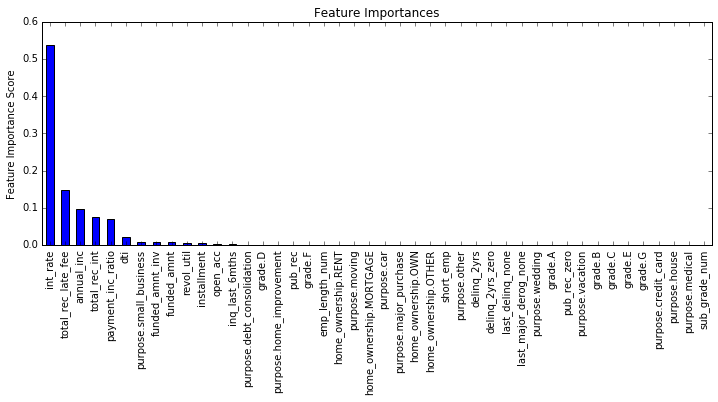

In [105]:
#model_5 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
#        target = target, features = features, max_iterations = 5)

#Note features = original features
#predictors would be all one-hot encoded categorical features and original numeric features

#Thus choose all predictors except target
predictors = [x for x in list(train_data.columns) if x not in [target]]

model_5 = GradientBoostingClassifier(max_depth=6,n_estimators=5) #,random_state=10)
model_5.fit(train_data[predictors], train_data[target])

modelfit(model_5, train_data, predictors)

# Making predictions

**10.** Just like we did in previous sections, let us consider a few positive and negative examples **from the validation set**. We will do the following:
* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

In [106]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.debt_consolidation,purpose.home_improvement,purpose.house,purpose.major_purchase,purpose.medical,purpose.moving,purpose.other,purpose.small_business,purpose.vacation,purpose.wedding
4672,1,0.2,0,3,29.44,6.30496,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4673,1,0.6,1,1,12.19,13.49520,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
0,-1,0.4,0,3,13.97,2.96736,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,-1,1.0,0,11,16.33,1.90524,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0


### Predicting on sample validation data

**11.** For each row in the **sample_validation_data**, write code to make **model_5** predict whether or not the loan is classified as a **safe loan**.

**Hint:** Use the `predict` method in `model_5` for this. If you are using scikit-learn, you can use the [.predict()](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.predict) method)

In [107]:
predictions = model_5.predict(sample_validation_data[predictors])
print predictions
print sample_validation_data[target]

[ 1  1 -1  1]
4672    1
4673    1
0      -1
1      -1
Name: safe_loans, dtype: int64


In [108]:
print "num of predictions +ve class:%d" %(predictions == +1).sum()
print "num of predictions -ve class:%d" %(predictions == -1).sum()
actuals = sample_validation_data[target]
num_correct = sum( np.equal(predictions, actuals))
num_mistakes = len(sample_validation_data) - num_correct
accuracy = 1. * num_correct/len(sample_validation_data)
print "-----------------------------------------------------"
print '# Reviews   correctly classified =', num_correct
print '# Reviews incorrectly classified =', num_mistakes
print '# Reviews total                  =', len(sample_validation_data)
print "-----------------------------------------------------"
print 'Accuracy = %.2f' % accuracy

num of predictions +ve class:3
num of predictions -ve class:1
-----------------------------------------------------
# Reviews   correctly classified = 3
# Reviews incorrectly classified = 1
# Reviews total                  = 4
-----------------------------------------------------
Accuracy = 0.75


**Quiz question:** What percentage of the predictions on `sample_validation_data` did `model_5` get correct?

### Prediction probabilities

**12.** For each row in the **sample_validation_data**, what is the probability (according **model_5**) of a loan being classified as **safe**? 

**Hint:** Set `output_type='probability'` to make **probability** predictions using `model_5` on `sample_validation_data`: If you are using scikit-learn, you can use the [.predict_proba()](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.predict_proba) method)

In [109]:
prob_predictions = model_5.predict_proba(sample_validation_data[predictors])
#print "%0.2f" %(predictions)
print "Prob predictions", prob_predictions[:,1 ]

#print [+1 if x >= 0.5 else -1 for x in enumerate(prob_predictions[:,1])]
prob_2_class = [+1 if x >= 0.5 else -1 for x in prob_predictions[:,1]]  
print "\nProb 2 class",prob_2_class

print "\nActual class labels\n", sample_validation_data[target]

Prob predictions [ 0.58357669  0.53050311  0.46192208  0.60408361]

Prob 2 class [1, 1, -1, 1]

Actual class labels
4672    1
4673    1
0      -1
1      -1
Name: safe_loans, dtype: int64


**Quiz Question:** According to **model_5**, which loan is the least likely to be a safe loan?

**Checkpoint:** Can you verify that for all the predictions with `probability >= 0.5`, the model predicted the label **+1**?

In [110]:
min_prob, index = min([(v,i) for i,v in enumerate(prob_predictions[:,1])])
print "Lowest probabilty of loan being safe = %0.4f for item at index %d" %(min_prob, index)

sample_validation_data.iloc[index]

Lowest probabilty of loan being safe = 0.4619 for item at index 2


safe_loans                       -1.00000
sub_grade_num                     0.40000
short_emp                         0.00000
emp_length_num                    3.00000
dti                              13.97000
payment_inc_ratio                 2.96736
delinq_2yrs                       3.00000
delinq_2yrs_zero                  0.00000
inq_last_6mths                    0.00000
last_delinq_none                  0.00000
last_major_derog_none             1.00000
open_acc                         14.00000
pub_rec                           0.00000
pub_rec_zero                      1.00000
revol_util                       59.50000
total_rec_late_fee                0.00000
int_rate                         16.77000
total_rec_int                   719.11000
annual_inc                    50004.00000
funded_amnt                    5000.00000
funded_amnt_inv                5000.00000
installment                     123.65000
grade.A                           0.00000
grade.B                           

In [111]:
prob_2_class = [+1 if x >= 0.5 else -1 for x in prob_predictions[:,1]]  
print "Number matching ", sum( np.equal(predictions, prob_2_class))

Number matching  4


## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

**13.** Evaluate the accuracy of the **model_5** on the **validation_data**.

**Hint**: Use the `.evaluate()` method in the model.

In [112]:
#model_5.evaluate(validation_data[predictors])  as given by graphlab create
#{'accuracy': 0.66813873330461,
# 'auc': 0.7247215702188436,

predictions = model_5.predict(validation_data[predictors])
predprob    = model_5.predict_proba(validation_data[predictors])[:,1]
true_labels = validation_data[target].values

print "Accuracy : %.4g" % metrics.accuracy_score(validation_data[target].values, predictions)
print "AUC Score (Train): %f" % metrics.roc_auc_score(validation_data[target].values, predprob)

Accuracy : 0.6614
AUC Score (Train): 0.716653


**14.** Calculate the number of **false positives** made by the model. False positives: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. False positives are predictions where the model predicts +1 but the true label is -1.

In [113]:
#np.sum([p == +1 and t == -1, for p in predictions, t in true_labels])
# sum([p == +1 for p in predictions]) and sum([ t == -1 for t in true_labels])   <-- give 4672!
false_positives = sum((predictions == +1) & (true_labels == -1))
false_positives #1618  graphlab

1653

**Quiz question**: What is the number of **false positives** on the **validation_data**?

**15.** Calculate the number of **false negatives** made by the model.

In [114]:
false_negatives = sum((predictions == -1) & (true_labels == +1))
false_negatives  #1463 graphlab

1491

## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded). In this assignment, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is $49.42M. That is a **lot of money**!.

**16.** Calculate the cost of mistakes made by model_5 on the validation_data.

In [115]:
total_cost = 10000 * false_negatives + 20000 * false_positives
print "Total_cost for wrong predictions: $%.2f" %total_cost  #$46990000.00 graphlab

Total_cost for wrong predictions: $47970000.00


**Quiz Question**: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (**model_5**) as evaluated on the **validation_set**?

**Reminder**: Compare the cost of the mistakes made by the boosted trees model with the decision tree model. The extra 3% improvement in prediction accuracy can translate to several million dollars!  And, it was so easy to get by simply boosting our decision trees.

## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

Quick revision sorting

*  DataFrame.sort(columns=None, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', **kwargs)
Sort DataFrame either by labels (along either axis) or by the values in column(s)

*    columns : Column name(s) in frame. Accepts a column name or a list for a nested sort. A tuple will be interpreted as the levels of a multi-index.
*    ascending : boolean or list, default True; Sort ascending vs. descending. Specify list for multiple sort orders
*    axis : {0 or ‘index’, 1 or ‘columns’}, default 0,    Sort index/rows versus columns

**17.** Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. Use `output_type = probability`.

In [116]:
validation_data['predictions'] = model_5.predict_proba(validation_data[predictors])[:,1]
validation_data.sort(columns='predictions', axis=0, ascending = False)
validation_data['predictions'].head(4)

/mnt/win-data/shared/stats-R/anaconda2/envs/conda_py2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


0    0.461922
1    0.604084
2    0.479872
3    0.406924
Name: predictions, dtype: float64

**Checkpoint:** For each row, the probabilities should be a number in the range **[0, 1]**. We have provided a simple check here to make sure your answers are correct.

In [117]:
print "Your loans      :\n%s\n" % validation_data['predictions'].head(4)
print "Expected answer : %s" % [0.4492515948736132, 0.6119100103640573,
                                0.3835981314851436, 0.3693306705994325]

Your loans      :
0    0.461922
1    0.604084
2    0.479872
3    0.406924
Name: predictions, dtype: float64

Expected answer : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]


**18.** Now, we are ready to go to **Step 3**. You can now use the `prediction` column to sort the loans in **validation_data** (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a **safe loan**.

In [118]:
validation_data['predictions'] = model_5.predict_proba(validation_data[predictors])[:,1]
validation_data.sort(columns='predictions', axis=0, ascending = False)
validation_data['predictions'].head(5)

/mnt/win-data/shared/stats-R/anaconda2/envs/conda_py2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


0    0.461922
1    0.604084
2    0.479872
3    0.406924
4    0.547199
Name: predictions, dtype: float64

** Quiz question**: What grades are the top 5 loans?

**19.** Let us repeat this excercise to find the top 5 loans (in the **validation_data**) with the **lowest probability** of being predicted as a **safe loan**:

In [119]:
print validation_data.tail(5)[ ['grade.A','grade.B','grade.C','grade.D','predictions'] ]

      grade.A  grade.B  grade.C  grade.D  predictions
9279        0        0        1        0     0.523047
9280        1        0        0        0     0.579741
9281        0        0        0        1     0.464690
9282        0        1        0        0     0.477191
9283        0        0        1        0     0.461922


**Checkpoint:** You should expect to see 5 loans with the grade ['**D**', '**C**', '**C**', '**C**', '**B**'].

## Effect of adding more trees

**20.** In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees.  We use the **max_iterations** parameter in the boosted tree module. 

If using skit-learn, use the **n_estimators** parameter to control the number of trees. Remember to keep **max_depth = 6**.
Let's get sarted with a model with **max_iterations = 10**:

Now, train 5 models with **max_iterations** to be:
* `max_iterations = 10`, 
* `max_iterations = 50`, 
* `max_iterations = 100`
* `max_iterations = 200`
* `max_iterations = 500`. 

Let us call these models **model_10**,**model_50**, **model_100**, **model_200**, and **model_500**. You can pass in `verbose=False` in order to suppress the printed output.

In graphlab,  each iterations corresponds to adding a tree, so number of trees is controlled by max_iterations parameter, so max_iterations=10 corresponds to adding 10 trees, bit wierd!!!!

 sklearn uses n_estimators parameter to control the number of trees, so n_estimator=10 corresponds to adding 10 trees.

**Warning:** This could take a couple of minutes to run.

In [120]:
model_10 = GradientBoostingClassifier(max_depth=6,n_estimators=10) #,random_state=10)
model_10.fit(train_data[predictors], train_data[target])

model_50 = GradientBoostingClassifier(max_depth=6,n_estimators=50) #,random_state=10)
model_50.fit(train_data[predictors], train_data[target])

model_100 = GradientBoostingClassifier(max_depth=6,n_estimators=100) #,random_state=10)
model_100.fit(train_data[predictors], train_data[target])

model_200 = GradientBoostingClassifier(max_depth=6,n_estimators=200) #,random_state=10)
model_200.fit(train_data[predictors], train_data[target])

model_500 = GradientBoostingClassifier(max_depth=6,n_estimators=500) #,random_state=10)
model_500.fit(train_data[predictors], train_data[target])

#
#model_10 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
#        target = target, features = features, max_iterations = 10, verbose=False)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Compare accuracy on entire validation set

**21.** Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the **accuracy** of the 10, 50, 100, 200, and 500 tree models on the **validation_data**. Use the `.evaluate` method.

In [135]:
print "Validation data, accuracy model 10  : %.4g" \
%(metrics.accuracy_score(validation_data[target].values, \
   model_10.predict(validation_data[predictors])))

print "Validation data, accuracy model 50  :%.4g" \
%(metrics.accuracy_score(validation_data[target].values, \
   model_50.predict(validation_data[predictors])))

print "Validation data, accuracy model 100 :%.4g" \
%(metrics.accuracy_score(validation_data[target].values, \
   model_100.predict(validation_data[predictors])))

print "Validation data, accuracy model 200 :%.4g" \
%(metrics.accuracy_score(validation_data[target].values, \
   model_200.predict(validation_data[predictors])))

print "Validation data, accuracy model 500 :%.4g" \
%(metrics.accuracy_score(validation_data[target].values, \
   model_500.predict(validation_data[predictors])))

for m in [model_10, model_50, model_100, model_200, model_500]:
    print "Model:", metrics.accuracy_score(validation_data[target].values, \
             m.predict(validation_data[predictors]))

Validation data, accuracy model 10  : 0.6663
Validation data, accuracy model 50  :0.6844
Validation data, accuracy model 100 :0.6891
Validation data, accuracy model 200 :0.6909
Validation data, accuracy model 500 :0.6896
Model: 0.666307626023
Model: 0.684403274451
Model: 0.689142610944
Model: 0.690866006032
Model: 0.689573459716


In [122]:
#Errors we got under graphlab
#Validation data, classification error (model 10  : 0.672770357604
#Validation data, classification error (model 50  : 0.690758293839
#Validation data, classification error (model 100 : 0.691727703576
#Validation data, classification error (model 200 : 0.684510986644
#Validation data, classification error (model 500 : 0.671800947867

**Quiz Question:** Which model has the **best** accuracy on the **validation_data**? model 10, gl gave model_500 

**Quiz Question:** Is it always true that the model with the most trees will perform best on test data? No, in fact with sklearn, we see that validation errors increase as we overfit, as itr usually should. Graphlab errors are therefore bit confusing, as validation actually get lower as model gets more and more complex!!

## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. You will need [matplotlib](http://matplotlib.org/downloads.html) in order to visualize the plots. 

**22.** First, define a function to make the plots.

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `.evaluate`. 

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


**23.** Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [142]:
train_err_10  = 1 - metrics.accuracy_score(train_data[target].values, \
   model_10.predict(train_data[predictors]))
train_err_50  = 1 - metrics.accuracy_score(train_data[target].values, \
   model_50.predict(train_data[predictors]))
train_err_100 = 1 - metrics.accuracy_score(train_data[target].values, \
   model_100.predict(train_data[predictors]))
train_err_200 = 1 - metrics.accuracy_score(train_data[target].values, \
   model_200.predict(train_data[predictors]))
train_err_500 = 1 - metrics.accuracy_score(train_data[target].values, \
   model_500.predict(train_data[predictors]))

#print metrics.classification(train_data[target].values,model_500.predict(train_data[predictors]))

**24.** Now, let us run **Step 2**. Save the training errors into a list called **training_errors**

In [143]:
training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

#training_errors = []
#for m in [model_10, model_50, model_100, model_200, model_500]:
#    training_errors.append(round(1 - m.evaluate(train_data)['accuracy'],2))
print training_errors



[0.32832692979392242, 0.28270506999113354, 0.25363389666568148, 0.21335876837099332, 0.13168005588543485]


**25.** Now, onto **Step 3**. Write code to compute the classification error on the **validation_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [144]:
validation_err_10  = 1- metrics.accuracy_score(validation_data[target].values, \
   model_10.predict(validation_data[predictors]))
validation_err_50  = 1- metrics.accuracy_score(validation_data[target].values, \
   model_50.predict(validation_data[predictors]))
validation_err_100  = 1- metrics.accuracy_score(validation_data[target].values, \
   model_100.predict(validation_data[predictors]))
validation_err_200  = 1- metrics.accuracy_score(validation_data[target].values, \
   model_200.predict(validation_data[predictors]))
validation_err_500  = 1- metrics.accuracy_score(validation_data[target].values, \
   model_500.predict(validation_data[predictors]))

**26.** Now, let us run **Step 4**. Save the training errors into a list called **validation_errors**

In [145]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]
validation_errors

[0.33369237397673412,
 0.31559672554933216,
 0.31085738905644122,
 0.30913399396811714,
 0.31042654028436023]

**27.** Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

**28.** Run the following code to visualize the plots.

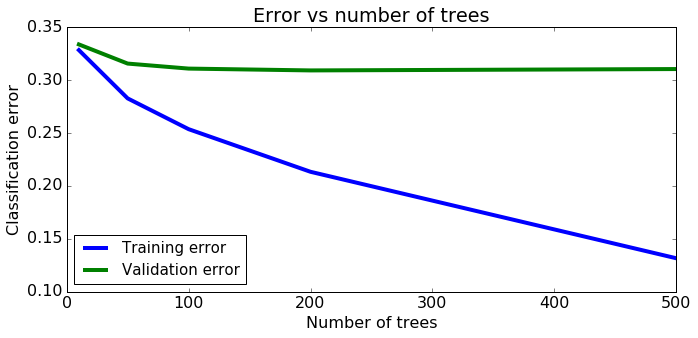

In [146]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

**Quiz question**: Does the training error reduce as the number of trees increases? Yes!

**Quiz question**: Is it always true that the validation error will reduce as the number of trees increases? No.